In [ ]:
from google.colab import drive
drive.mount('/content/drive')



In [23]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [24]:
!cp /content/drive/MyDrive/Docs/kaggle/kaggle.json ~/.kaggle/kaggle.json

In [26]:
! chmod 600 ~/.kaggle/kaggle.json

In [27]:
! kaggle competitions download titanic

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 71.5MB/s]


In [31]:
! unzip titanic.zip -d /content/titanic

Archive:  titanic.zip
  inflating: /content/titanic/gender_submission.csv  
  inflating: /content/titanic/test.csv  
  inflating: /content/titanic/train.csv  


In [ ]:
def visualizeAgainstSurvived(column, data):
    fig, axs = plt.subplots(figsize=(30, 10))
    sns.countplot(x=column, hue='Survived', data=data)

    plt.xlabel(column, size=1, labelpad=1)
    plt.ylabel('Survived', size=1, labelpad=1)
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=10)

    plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    plt.title('Count of Survival in {} Feature'.format(column), size=15, y=1.05)

    plt.show()

def extractTitle(data, column):
    # Mrs - married
    # Miss - unmarries
    # Mme - madame == Mrs
    # Mlle - Mademoiselle == Miss
    # Ms - not indicate marital status
    # Countess - middle noble
    # Jonkheer - lowest noble
    # Lady - he equivalent of lord, noble
    # Master - for boys and young men

    titleRegex = r'(Mr\.|Miss\.|Mrs\.|Master\.|Major\.|Dr\.|Capt\.|Rev\.|Don\.|Countess\.|Ms\.|Mme\.|Mlle\.|Col\.|Jonkheer\.|Dona\.|Lady\.|Sir\.)'
    titles = data[column].str.extract(titleRegex)
    titles = titles.replace(['Mme.', 'Dona.'], 'Mrs.')
    titles = titles.replace(['Mlle.', 'Ms.'], 'Miss.')
    titles = titles.replace(['Lady.','Countess.'], 'Noblefemale.')
    titles = titles.replace(['Don.', 'Jonkheer.'], 'Mr.')
    titles = titles.replace(['Dr.', 'Major.', 'Col.'], 'Dr/Major')
    return titles

def show_correlation(data):
    print(data.corr(numeric_only=True)["Survived"].sort_values(ascending=False))

# Get Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# def concat_df(train_data, test_data):
#     return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

# all_data = concat_df(train_data, test_data)

# Explore

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
train_data.groupby(['Embarked','Pclass'])[['PassengerId','Cabin']].agg(['count','unique'])

PassengerId  \
                      count   
Embarked Pclass               
C        1               85   
         2               17   
         3               66   
Q        1                2   
         2                3   
         3               72   
S        1              127   
         2              164   
         3              353   

                                                                   Cabin  \
                                                            unique count   
Embarked Pclass                                                            
C        1       [2, 31, 32, 35, 53, 55, 65, 97, 98, 119, 140, ...    66   
         2       [10, 44, 123, 136, 182, 293, 309, 362, 390, 47...     2   
         3       [20, 27, 37, 40, 43, 49, 58, 61, 66, 74, 112, ...     1   
Q        1                                              [246, 413]     2   
         2                                         [304, 323, 627]     1   
         3       [6, 17, 23, 29, 33, 45, 47, 48, 83, 110, 117, ...     1   
S        1       [4, 7, 12, 24, 28, 36, 56, 63, 84, 89, 93, 103...   106   
         2       [16, 18, 21, 22, 34, 42, 54, 57, 59, 67, 71, 7...    13   
         3       [1, 3, 5, 8, 9, 11, 13, 14, 15, 19, 25, 26, 30...    10   

                                                                    
                                                            unique  
Embarked Pclass                                                     
C        1       [C85, nan, B78, D33, B30, A5, D10 D12, B58 B60...  
         2                                                [nan, D]  
         3                                            [nan, F E69]  
Q        1                                                   [C78]  
         2                                             [E101, nan]  
         3                                              [nan, F38]  
S        1       [C123, E46, C103, A6, C23 C25 C27, nan, C52, C...  
         2                   [nan, D56, F33, E101, F2, F4, D, E77]  
         3                      [nan, G6, F G73, E10, F G63, E121]

In [ ]:
train_data[train_data['Ticket'].isin(['PC 17569'])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C
195,196,1,1,"Lurette, Miss. Elise",female,58.0,0,0,PC 17569,146.5208,B80,C


In [ ]:
train_data.corr(numeric_only=True)["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

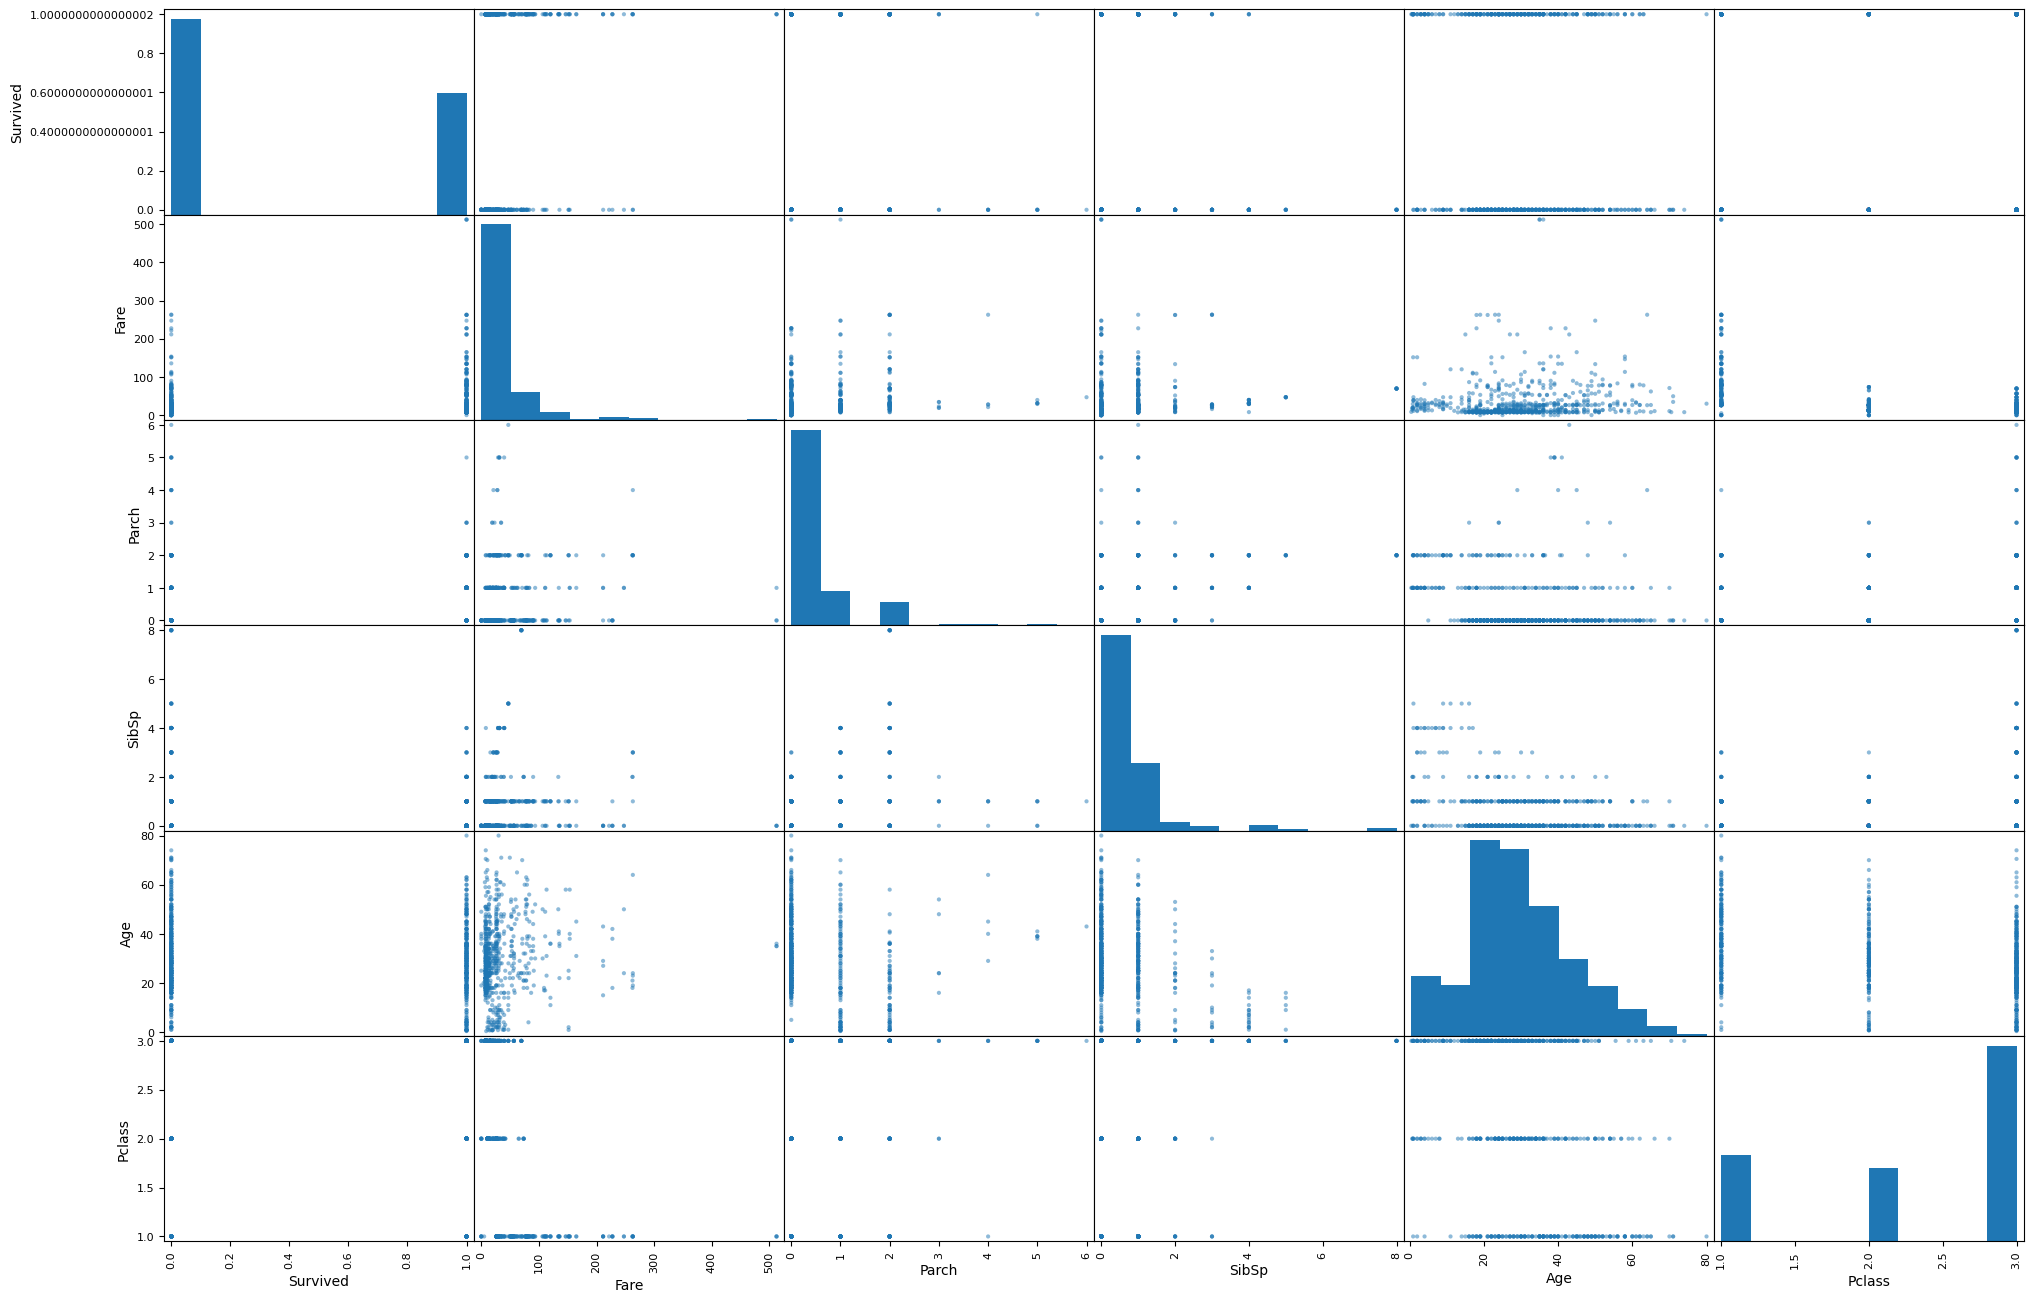

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["Survived", "Fare", "Parch", "SibSp", "Age","Pclass", "Sex"]
scatter_matrix(train_data[attributes], figsize=(24,16))

plt.show()

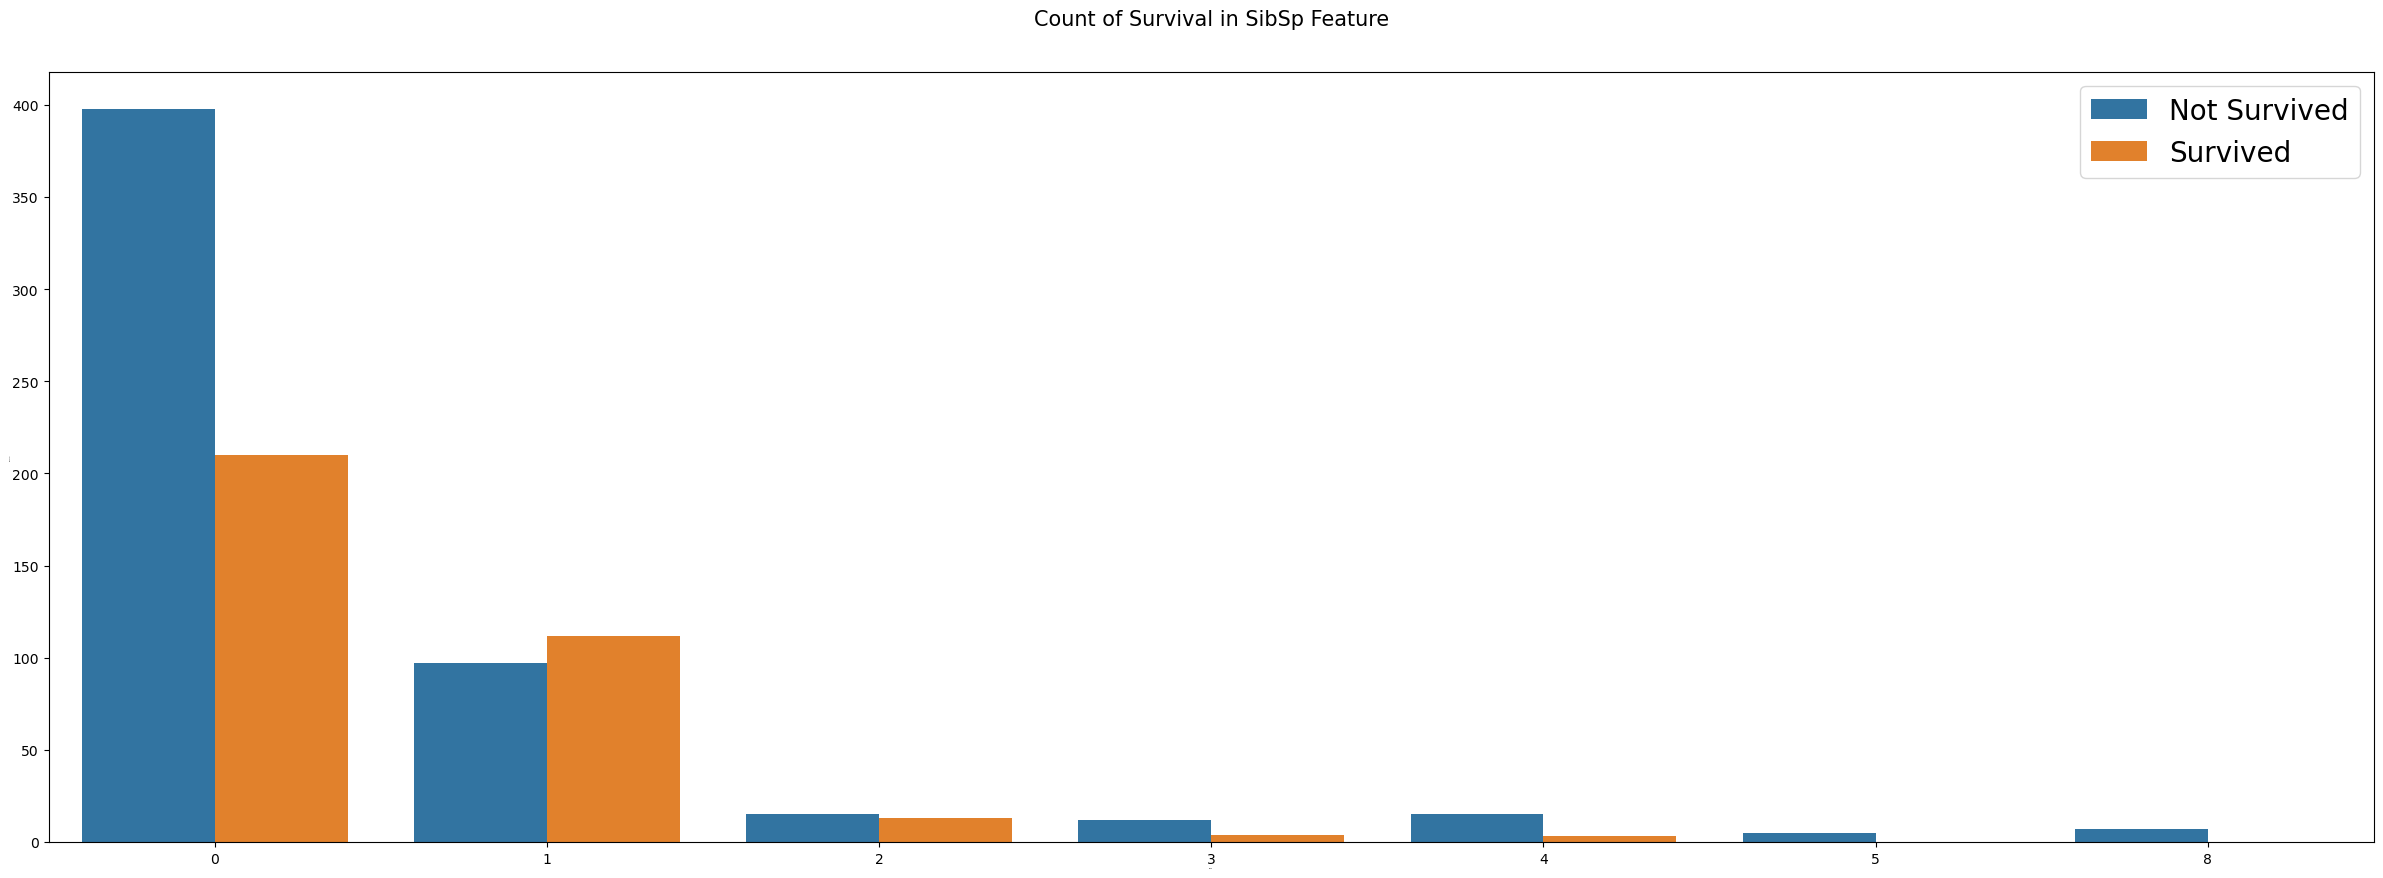

In [ ]:
visualizeAgainstSurvived('SibSp', train_data)

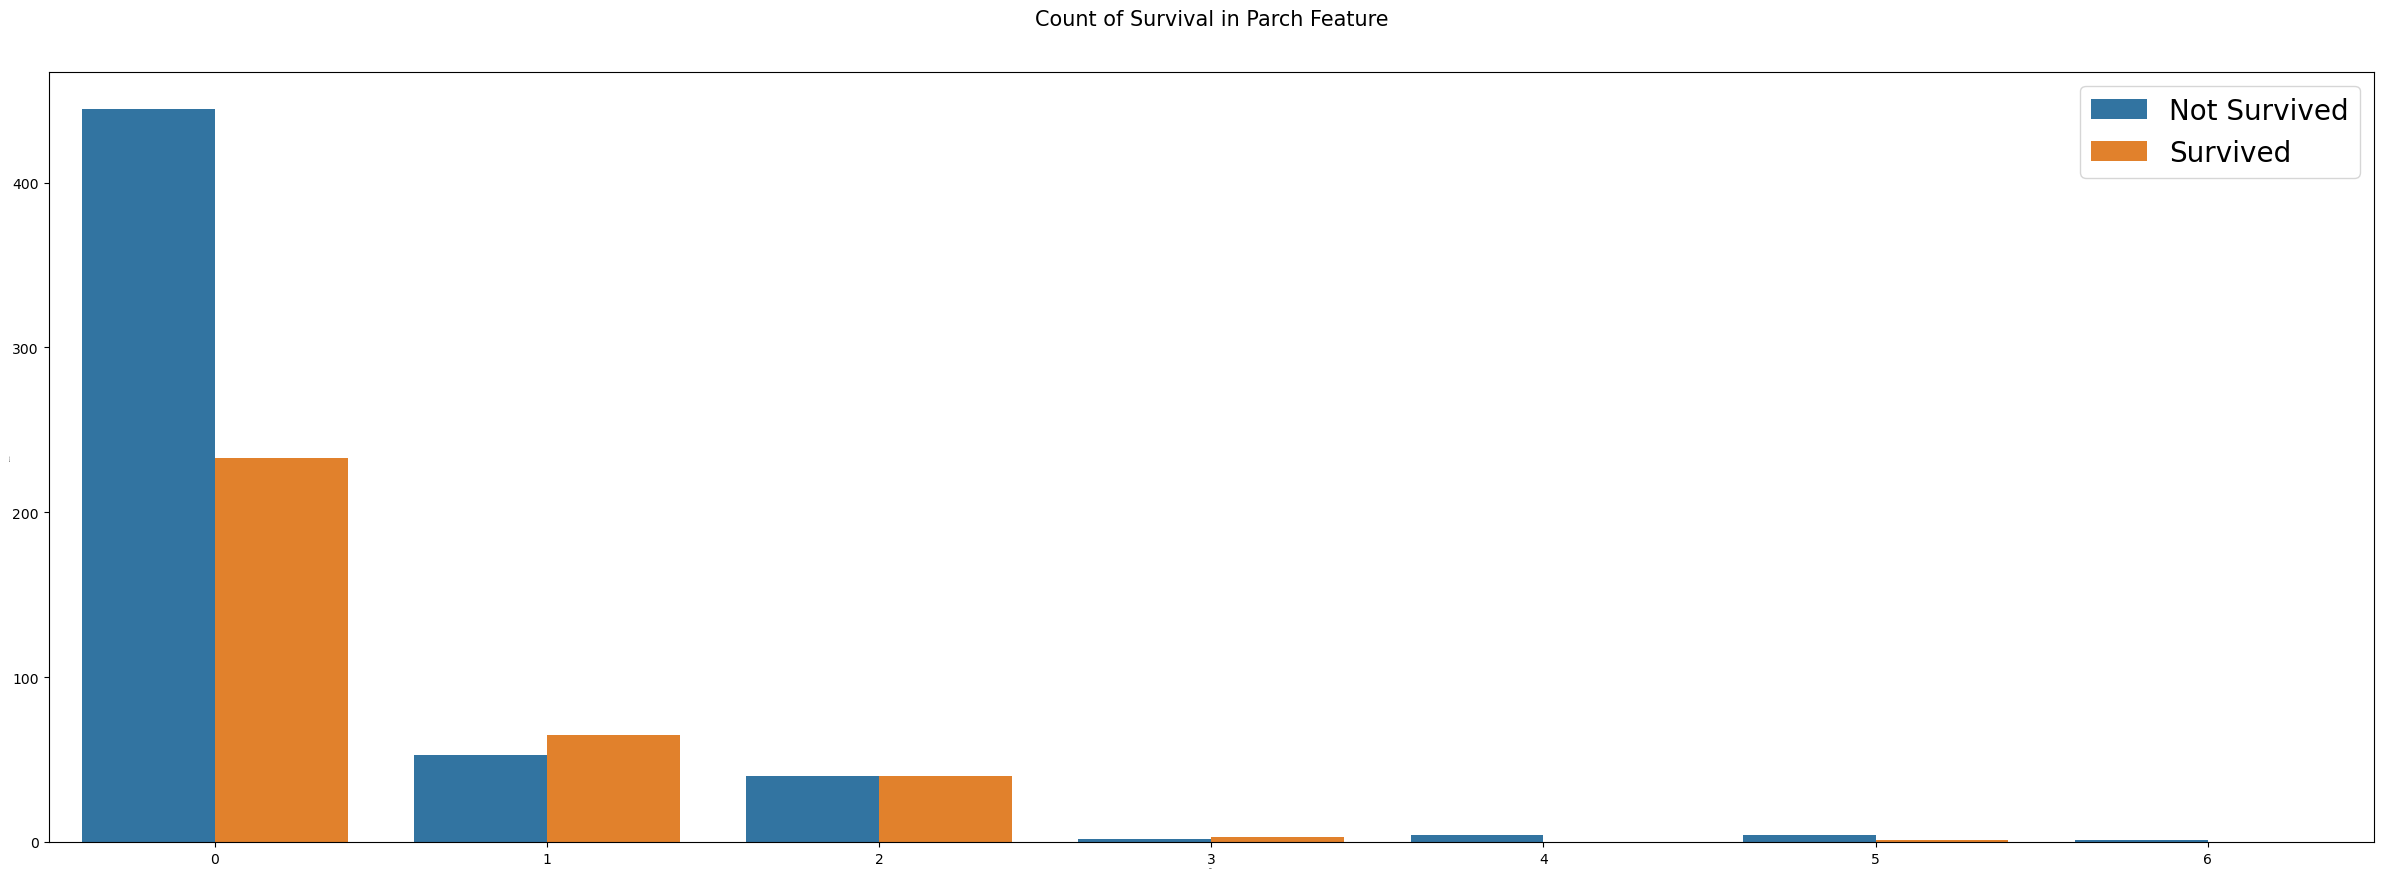

In [ ]:
visualizeAgainstSurvived('Parch', train_data)

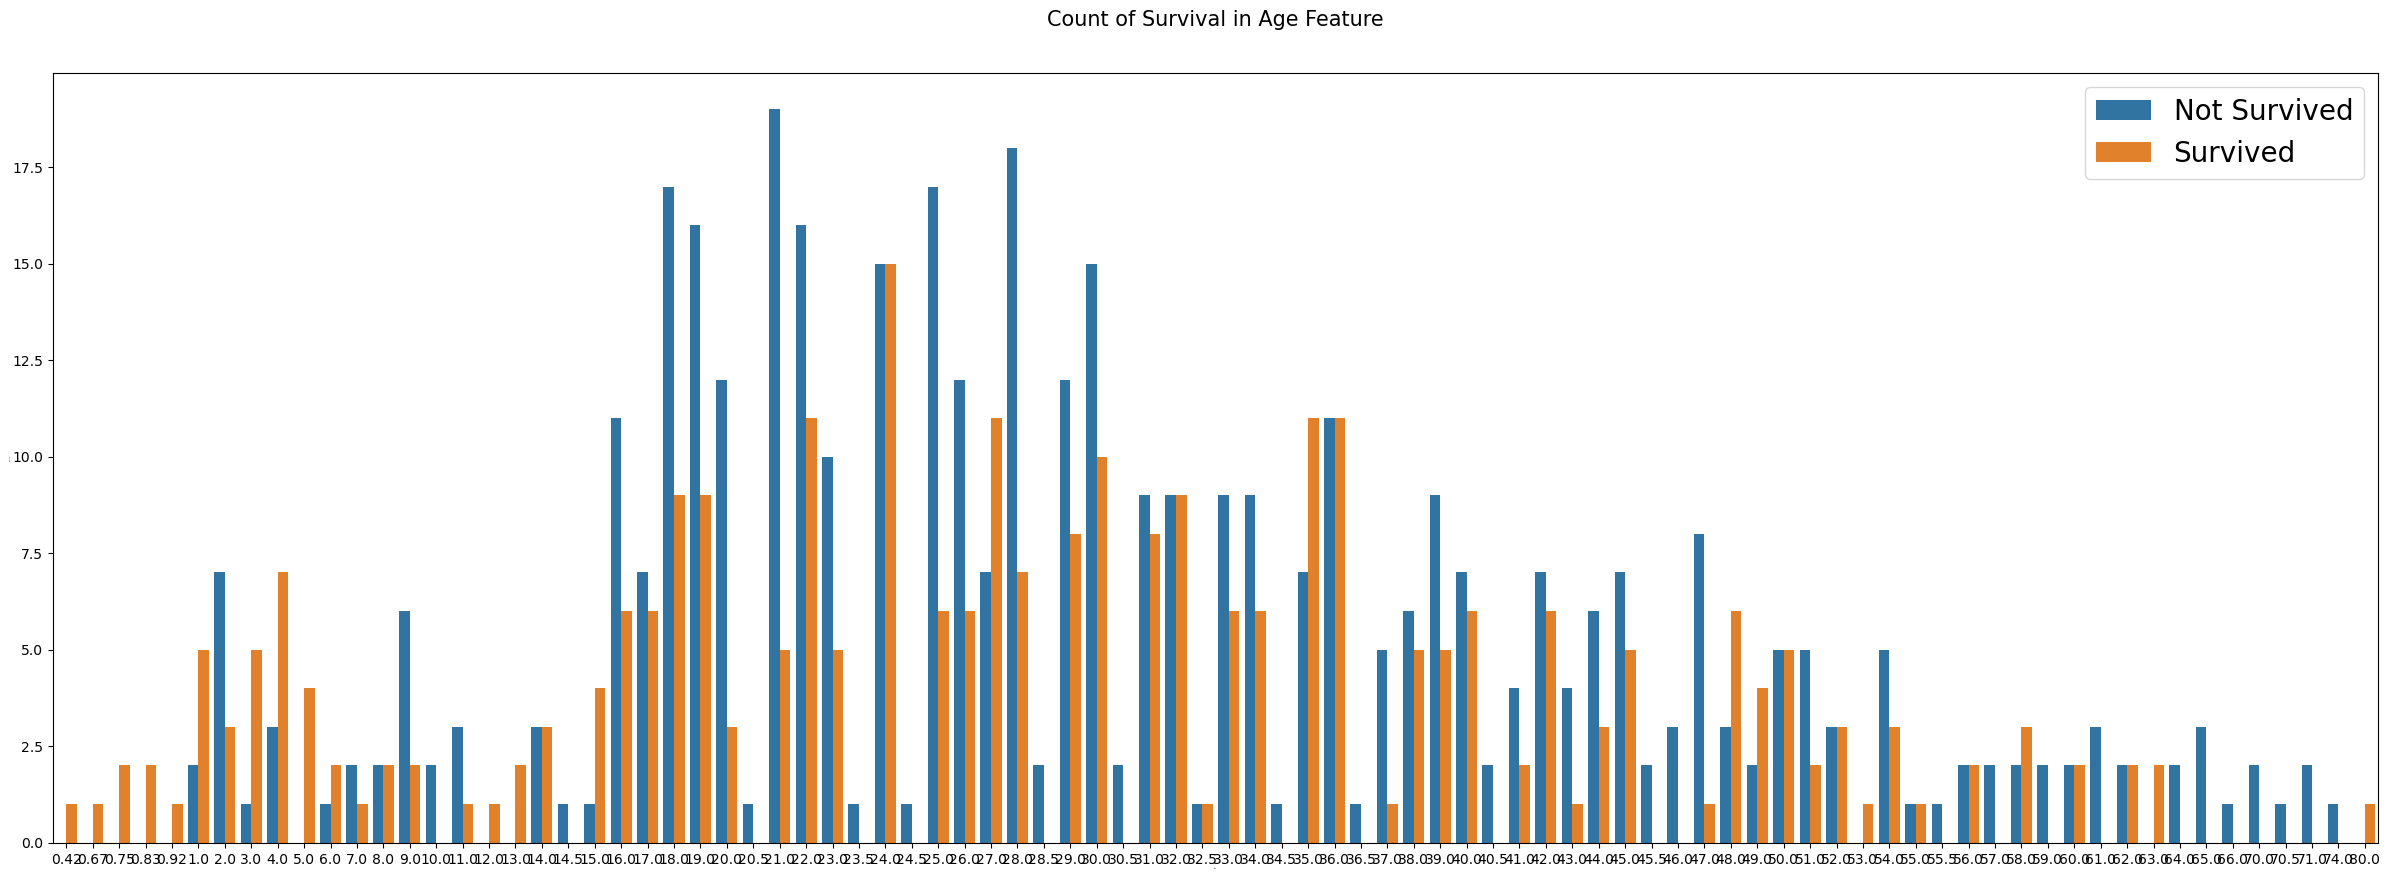

In [ ]:
visualizeAgainstSurvived('Age', train_data)

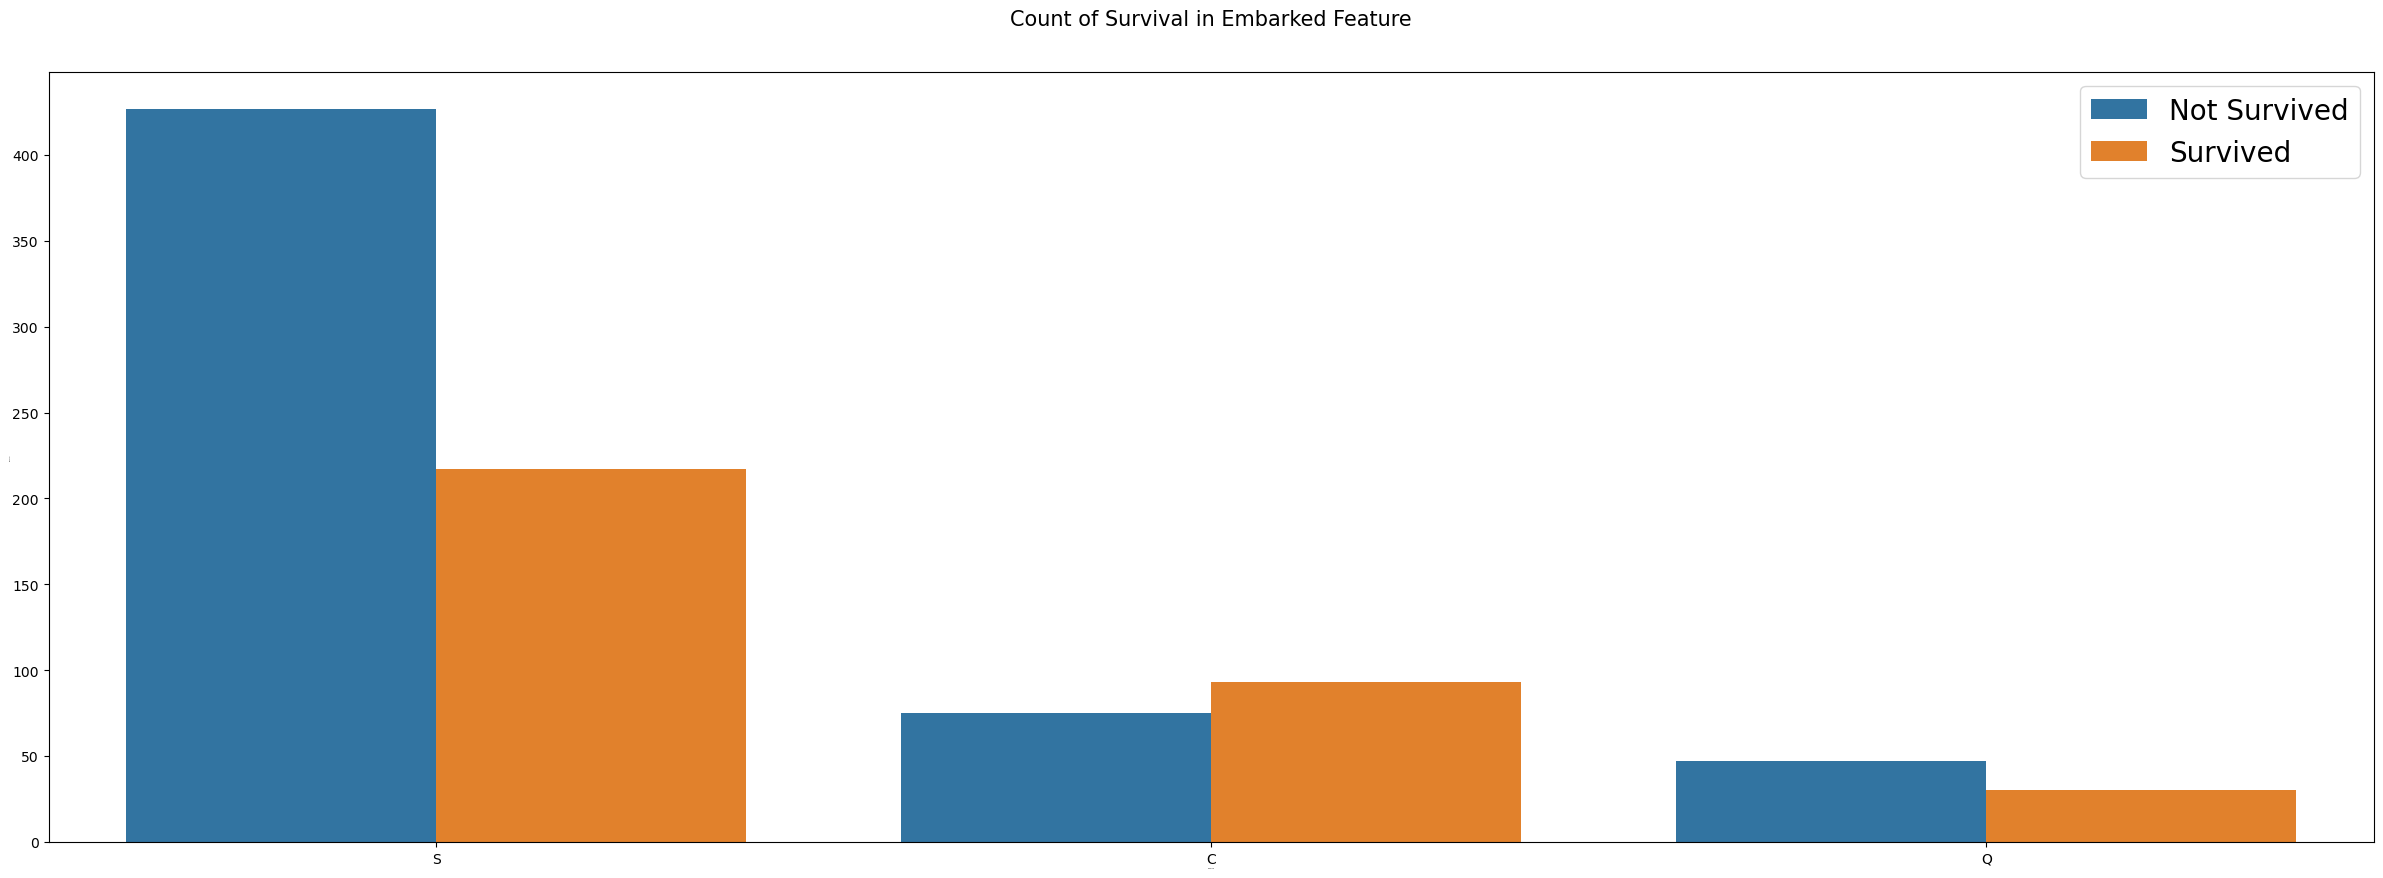

In [ ]:
visualizeAgainstSurvived('Embarked', train_data)

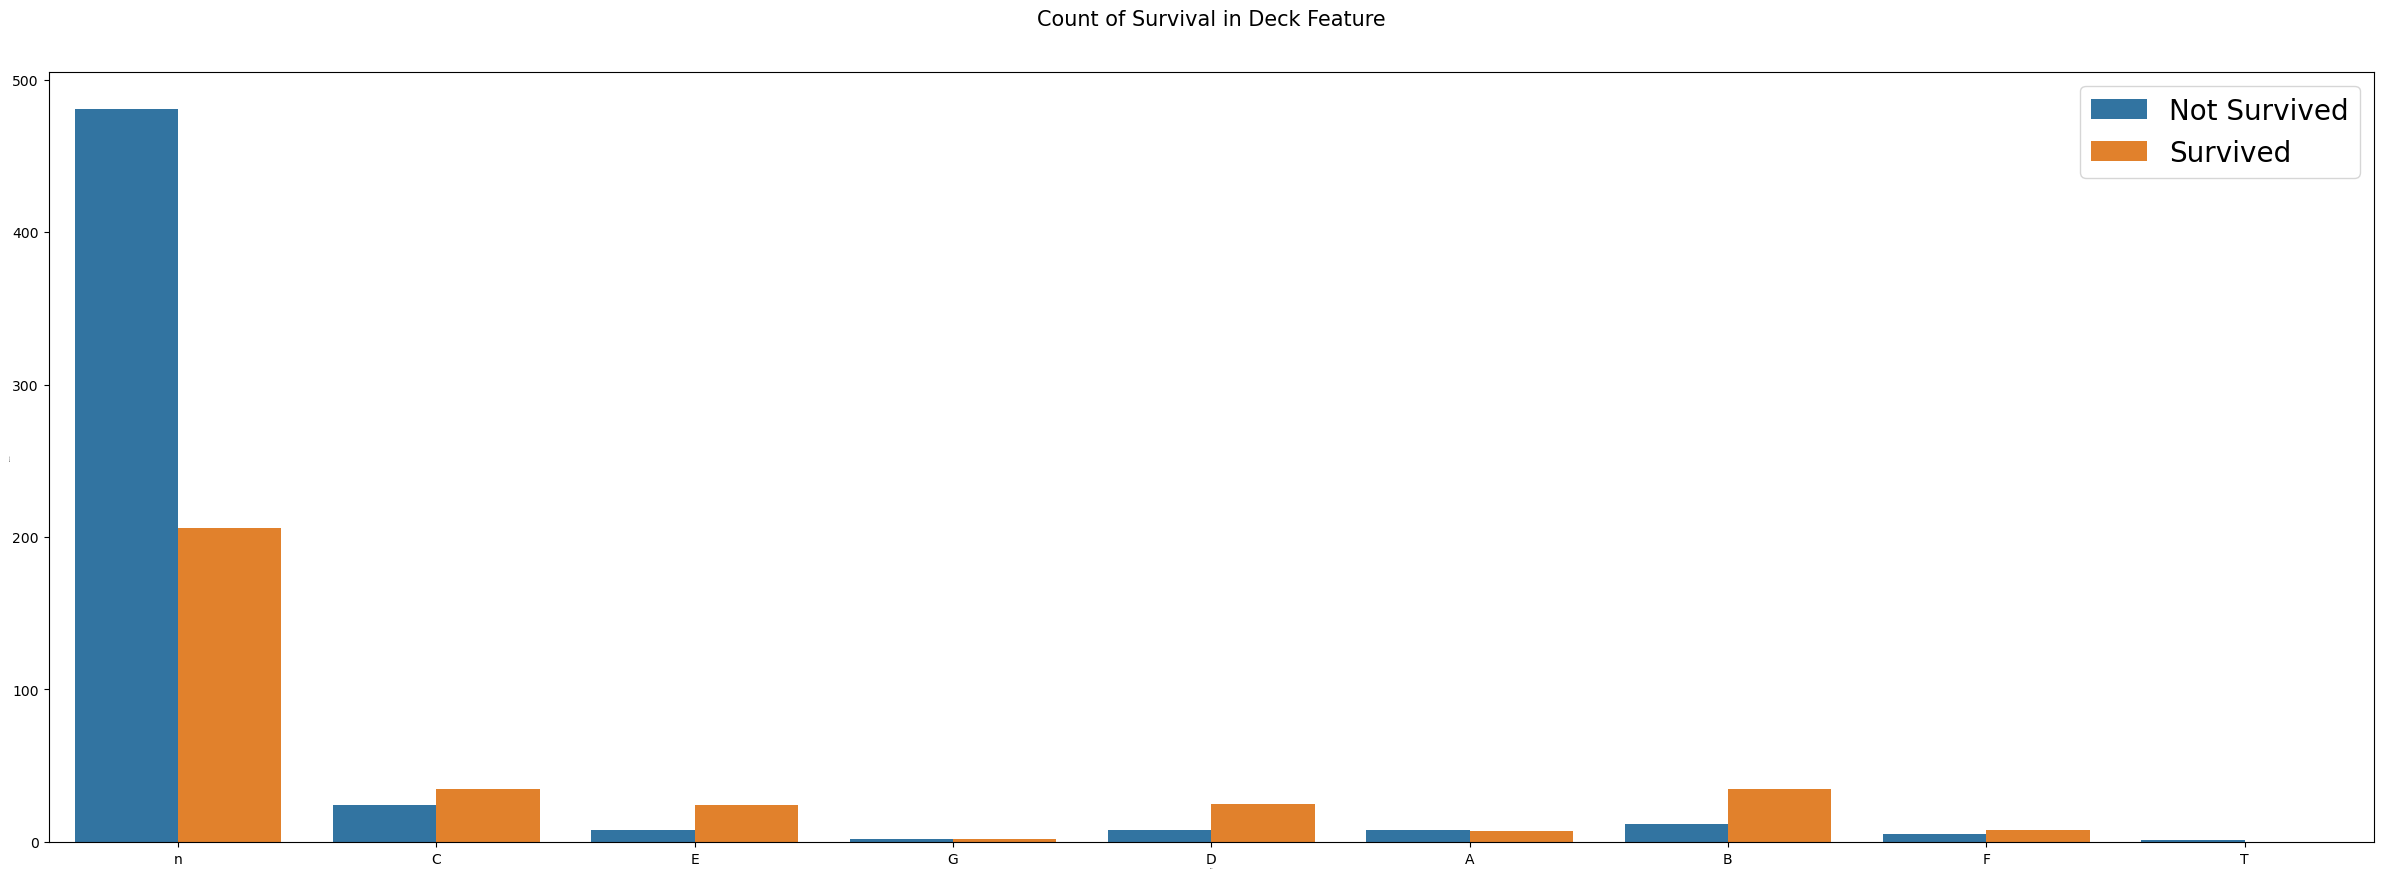

In [ ]:
decks = train_data['Cabin'].astype(str).str[0]
decka_data = pd.DataFrame({"Survived": train_data['Survived'],"Deck": decks})
visualizeAgainstSurvived('Deck', decka_data)

# Data preparation

# Pipeline

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer


def sum(data):
    return pd.DataFrame(data['SibSp'] + data['Parch'])


fare_pipeline = make_pipeline(SimpleImputer(strategy='mean'), KBinsDiscretizer(9, strategy='quantile', encode='ordinal'))
title_pipeline = make_pipeline(FunctionTransformer(extractTitle, kw_args={'column':'Name'}), OrdinalEncoder())
age_pipeline = make_pipeline(KNNImputer(n_neighbors=2), MinMaxScaler())
relatives = make_pipeline(FunctionTransformer(sum, validate=False))
pclass = make_pipeline(OneHotEncoder())
embarked = make_pipeline(OneHotEncoder())
# cabin = make_pipeline(KNNImputer(n_neighbors=5), LabelEncoder())

preprocessing = ColumnTransformer([
    ("fare", fare_pipeline, ["Fare"]),
    ("name", title_pipeline, ['Name']),
    ("age", age_pipeline, ['Age']),
    ("relatives", relatives, ["SibSp", "Parch"]),
    ("categorogical", pclass, ['Pclass', "Sex"]),
    ("embarked", embarked, ['Embarked']),
#     ("cabin", cabin, ['Cabin']),
])

# train_data_prepared = preprocessing.fit_transform(train_data)

# train_data_fr = pd.DataFrame(
#     train_data_prepared,
#     columns=pd.Index(["Fare", "Title","Age", "Relatives", "Class_1","Class_2","Class_3", "Sex_1", "Sex_2"]),
#     index=train_data.index)

# train_data_fr["Survived"] = train_data["Survived"]
# train_data_fr[["Fare","Age"]] = train_data_fr[["Fare","Age"]].astype(float)
# train_data_fr['Title'] = train_data_fr['Title']


# show_correlation(train_data_fr)
# train_data_fr.head()
# train_data[["Fare","Title", "Age"]] = preprocessing.fit_transform(train_data)
# train_data[["Fare","Age"]]= train_data[["Fare","Age"]].astype('float64')
# # train_data['Age'] = train_data['Age'].astype(float)
# show_correlation(train_data)
# # # visualizeAgainstSurvived('Title', train_data)
# train_data.info()
# train_data.head()

# Train Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

labels = train_data["Survived"]

model = make_pipeline(preprocessing, RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0))
model.fit(train_data, labels)


predictions = model.predict(test_data)
predictions = predictions.astype(int)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [ ]:
# all_data['Embarked'] = all_data['Embarked'].fillna('S')

In [ ]:
# all_data.loc[(all_data['Pclass']==1) & (all_data['Cabin']=='T'), 'Cabin'] = 'C'
# all_data.loc[all_data.isnull()['Cabin'], 'Cabin'] = 'M'
# all_data['Deck'] =  all_data['Cabin'].astype(str).str[0]

# all_data['Deck'] = all_data['Deck'].replace(['A', 'B', 'C'], 'ABC')
# all_data['Deck'] = all_data['Deck'].replace(['D', 'E'], 'DE')
# all_data['Deck'] = all_data['Deck'].replace(['F', 'G'], 'FG')


In [ ]:
# all_data['Fare'] = all_data.groupby([ 'Deck', 'Relatives'])['Fare'].apply(lambda x: x.fillna(x.median()))

# all_data['Fare'] = pd.qcut(all_data['Fare'], 13)

In [ ]:
# # all_data['Group'] = all_data.groupby([ 'Ticket']).apply(lambda x: x['Group'] = x.median())

# all_data['Group'] = all_data.groupby('Ticket')['Ticket'].transform('count')
# # all_data.head()
# # all_data['Fare'] = pd.qcut(all_data['Fare'], 13)

In [ ]:
# train_data, test_data = all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

In [ ]:
# from sklearn.model_selection import train_test_split
# train_data, test = train_test_split(train_data, test_size=0.4)

# from sklearn.ensemble import RandomForestClassifier

# y = train_data["Survived"]

# features = [
#     "Pclass",
#     "Sex",
#     "Relatives",
#     "Embarked",
#     "Deck",
#     "Title",
#     "Fare",
#     'Group'
# ]
# X = pd.get_dummies(train_data[features])
# X_test = pd.get_dummies(test_data[features])
# print(X.T.index)
# print(X_test.T.index)


# model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
# model.fit(X, y)
# predictions = model.predict(X_test)
# predictions = predictions.astype(int)

# output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
# output.to_csv('my_submission.csv', index=False)
# print("Your submission was successfully saved!")

# # train only

# testY = test['Survived']
# Xtest = pd.get_dummies(test[features])
# print(Xtest.T.index)

# model.score(Xtest, testY)